In [3]:
from google.colab import files
import os

# 1. Upload the kaggle.json you just downloaded
files.upload()

# 2. Setup the directory for the API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# 1. Download the CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# 2. Unzip it (it will create a folder called 'train' and 'test')
import zipfile
with zipfile.ZipFile("cifake-real-and-ai-generated-synthetic-images.zip", 'r') as zip_ref:
    zip_ref.extractall("cifake_data")

# 3. Define your paths for Member 1 code
TRAIN_DIR = "/content/cifake_data/train"
TEST_DIR = "/content/cifake_data/test"

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.67GB/s]


In [5]:
!pip install -q tqdm torch torchvision grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import cv2

# --- Preprocessing Utilities ---
def high_pass_filter(image_tensor):
    img = image_tensor.permute(1, 2, 0).numpy()
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    hpf = img - blurred
    return torch.from_numpy(hpf).permute(2, 0, 1)

def simulate_jpeg_compression(image_pil, quality=10):
    import io
    from PIL import Image
    buffer = io.BytesIO()
    image_pil.save(buffer, "JPEG", quality=quality)
    buffer.seek(0)
    return Image.open(buffer)

def convert_to_ycbcr(image_pil):
    return image_pil.convert('YCbCr')

# --- Data Pipeline Setup ---
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_transform = transforms.Compose([
    # Uncomment for Unique Flexes:
    transforms.Lambda(lambda x: simulate_jpeg_compression(x, quality=30)),
    # transforms.Lambda(lambda x: convert_to_ycbcr(x)),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: high_pass_filter(x)),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# --- Model Definition ---
def get_detector_model():
    model = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    return model

# --- Training Logic ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss/len(loader), 100.*correct/total

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100.*correct/total

In [ ]:
# 1. Initialize Loaders
train_set = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
test_set = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# 2. Initialize Hardware & Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_detector_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Main Loop
num_epochs = 10
print(f"Training on {device}...")

for epoch in range(num_epochs):
    loss, acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_acc = evaluate(model, test_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss:.4f} | Train Acc: {acc:.2f}% | Val Acc: {val_acc:.2f}%")
    torch.save(model.state_dict(), 'cifake_resnet18_latest.pth')

print("Training Complete! Saved weights to 'cifake_resnet18_latest.pth'")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 98.2MB/s]


Training on cuda...


Training:  82%|████████▏ | 642/782 [01:06<00:14,  9.62it/s]


KeyboardInterrupt: 

Classes: ['FAKE', 'REAL']
Model loaded successfully
Accuracy: 0.95565
Precision: 0.9839617631439193
Recall: 0.9264
F1: 0.9543136749935617


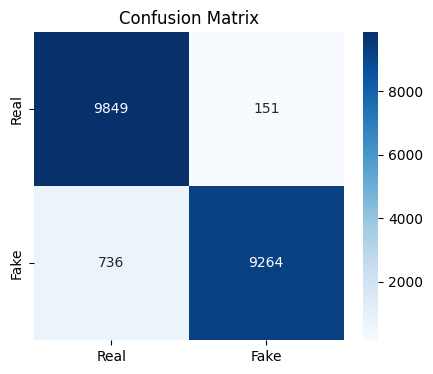

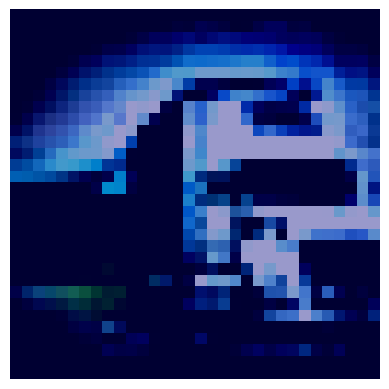

GradCAM saved!


In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ==============================
# PATHS
# ==============================
BASE_PATH = "/content/authentica-ai"
MODEL_PATH = "/content/cifake_resnet18_latest.pth"
TEST_DIR = "/content/cifake_data/test"

# ==============================
# DEVICE
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# LOAD DATASET
# ==============================
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Classes:", test_dataset.classes)

# ==============================
# LOAD TRAINED MODEL
# ==============================
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully")

# ==============================
# EVALUATION METRICS
# ==============================
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs,1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Accuracy:",acc)
print("Precision:",prec)
print("Recall:",rec)
print("F1:",f1)

# ==============================
# CONFUSION MATRIX
# ==============================
cm = confusion_matrix(all_labels, all_preds)
os.makedirs(f"{BASE_PATH}/results/metrics", exist_ok=True)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real","Fake"],
            yticklabels=["Real","Fake"])
plt.title("Confusion Matrix")
plt.savefig(f"{BASE_PATH}/results/metrics/confusion_matrix.png")
plt.show()

# ==============================
# GRADCAM
# ==============================
features = None
def hook_fn(module, input, output):
    global features
    features = output

model.layer4.register_forward_hook(hook_fn)

images, labels = next(iter(test_loader))
images = images.to(device)

output = model(images)

heatmap = torch.mean(features, dim=1)[0].cpu().detach().numpy()
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)+1e-8
heatmap = cv2.resize(heatmap,(32,32))

img = images[0].cpu().permute(1,2,0).numpy()
os.makedirs(f"{BASE_PATH}/results/gradcam", exist_ok=True)
plt.imshow(img)
plt.imshow(heatmap,cmap="jet",alpha=0.4)
plt.axis("off")
plt.savefig(f"{BASE_PATH}/results/gradcam/heatmap.png")
plt.show()

print("GradCAM saved!")

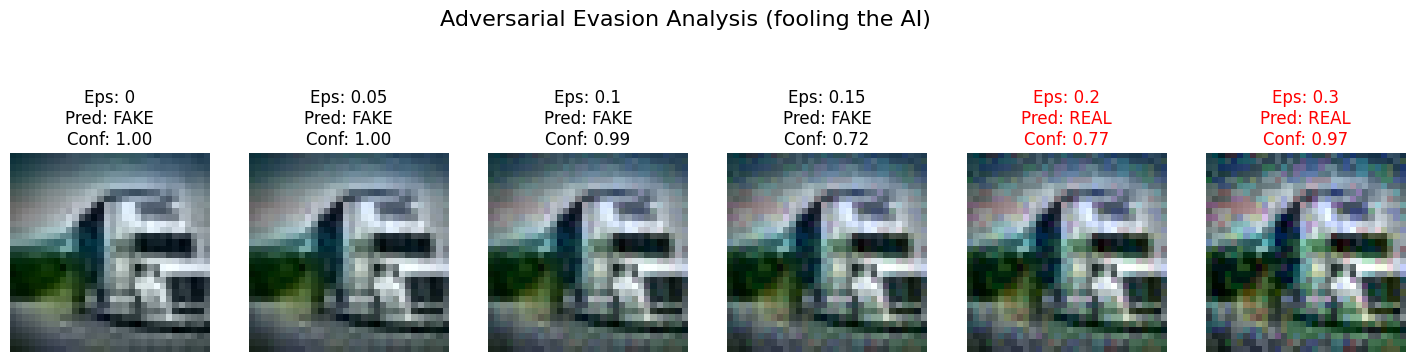

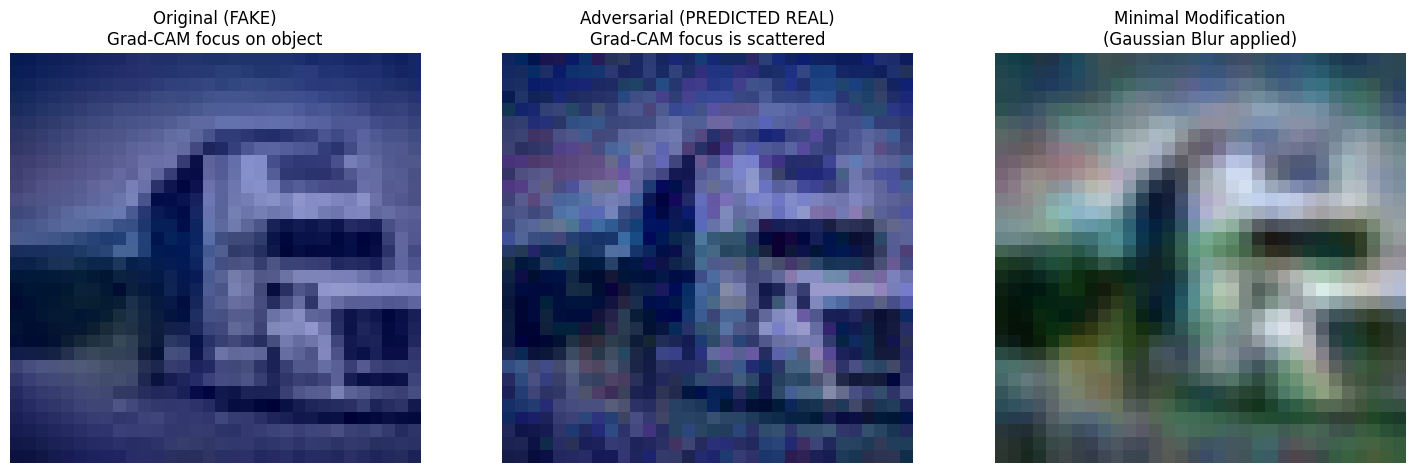

Task Completed: Original vs Modified images displayed with Grad-CAM shift.
Evaluating accuracy under attack (Epsilon: 0.1)...


  5%|▍         | 15/313 [00:01<00:23, 12.51it/s]


--- PHASE 2 RESULTS ---
Adversarial Accuracy: 49.71%
Evasion Success Rate (Fakes predicted as Real): 50.29%


In [8]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 1. SETUP ATTACK PARAMETERS
# Epsilon (ε) is the noise strength. 0 means no change. 0.3 is visible noise.
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.3]

# Mean and Std from Member 1 (used to bring image back to normal colors for display)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """Converts a normalized tensor back into a viewable RGB image."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) # Multiply by std and add mean (reverse of normalization)
    return torch.clamp(tensor, 0, 1) # Ensure pixels stay in valid [0, 1] range

def fgsm_attack(image, epsilon, data_grad):
    """The Fast Gradient Sign Method (FGSM) logic."""
    # Find the direction of the gradient (which pixels 'hurt' the model's accuracy)
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by moving pixels in that 'harmful' direction
    perturbed_image = image + epsilon * sign_data_grad

    # Keep the image math consistent with its original normalized range
    perturbed_image = torch.clamp(perturbed_image, image.min(), image.max())
    return perturbed_image

# 2. SELECT A "VICTIM" IMAGE
# We need a Fake image that the model CURRENTLY predicts correctly as Fake.
model.eval() # Put model in evaluation mode
found = False

for imgs, lbls in test_loader:
    imgs, lbls = imgs.to(device), lbls.to(device)
    output = model(imgs) # Run image through model
    _, pred = output.max(1) # Get the current prediction

    for i in range(len(lbls)):
        # Check if Actual is FAKE (0) and Model also says FAKE (0)
        if lbls[i].item() == 0 and pred[i].item() == 0:
            # .detach().clone() creates a fresh 'leaf' variable to avoid PyTorch errors
            target_image = imgs[i].unsqueeze(0).detach().clone()
            target_label = lbls[i].unsqueeze(0)
            found = True
            break
    if found: break

# 3. RUN THE ATTACK TRAJECTORY
# This loop applies increasing levels of noise to see when the model "breaks"
fig, axes = plt.subplots(1, len(epsilons), figsize=(18, 5))

for i, eps in enumerate(epsilons):
    # Prepare a fresh copy of the image and tell PyTorch to track pixel math (gradients)
    temp_img = target_image.clone().detach()
    temp_img.requires_grad = True

    # FORWARD PASS: Get the model's prediction
    output = model(temp_img)
    loss = F.cross_entropy(output, target_label) # Calculate how 'correct' it is

    # BACKWARD PASS: Calculate the 'Gradient' (which pixels to change)
    model.zero_grad()
    loss.backward()

    # APPLY ATTACK: Create the noisy adversarial image
    adv_image = fgsm_attack(temp_img, eps, temp_img.grad.data)

    # TEST THE ATTACK: See if the model is fooled
    with torch.no_grad():
        adv_out = model(adv_image)
        adv_pred = adv_out.argmax(1).item() # The new (hopefully wrong) prediction
        conf = F.softmax(adv_out, dim=1).max().item() # Confidence in that prediction

    # VISUALIZATION: Show the results
    img_show = denormalize(adv_image.squeeze().cpu().detach()) # Prep for display
    axes[i].imshow(img_show.permute(1, 2, 0)) # Change (C, H, W) to (H, W, C) for Matplotlib

    res_label = "REAL" if adv_pred == 1 else "FAKE"
    # SUCCESS: If prediction is REAL (1), title turns RED to show the model was FOOLED
    title_color = 'red' if adv_pred == 1 else 'black'

    axes[i].set_title(f"Eps: {eps}\nPred: {res_label}\nConf: {conf:.2f}", color=title_color)
    axes[i].axis('off')

plt.suptitle("Adversarial Evasion Analysis (fooling the AI)", fontsize=16)
plt.show()

# ==============================================================
# ANALYSIS & GRAD-CAM COMPARISON (FIXED)
# ==============================================================
import cv2

# 1. APPLY BLUR (Minimal Modification Task)
# Re-scaling to 0-255 for OpenCV operations
adv_img_255 = (denormalize(adv_image.squeeze().cpu().detach()).permute(1,2,0).numpy() * 255).astype(np.uint8)
blurred_adv = cv2.GaussianBlur(adv_img_255, (3, 3), 0)

# 2. GRAD-CAM COMPARISON FUNCTION
def get_gradcam_heatmap(input_tensor):
    # .detach().clone() creates a fresh copy to avoid memory graph issues
    fresh_input = input_tensor.detach().clone()
    fresh_input.requires_grad = True

    model.zero_grad()
    output = model(fresh_input)

    # We use .backward() here to get gradients for the heatmap
    output.max(1)[0].backward()

    # 'features' is updated via the hook from Member 2's code
    heatmap = torch.mean(features, dim=1)[0].cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return cv2.resize(heatmap, (32, 32))

# Generate Heatmaps using the fixed function
# We use .detach() to ensure we aren't carrying old math history
orig_heatmap = get_gradcam_heatmap(target_image.detach())
adv_heatmap = get_gradcam_heatmap(adv_image.detach())

# 3. FINAL VISUAL COMPARISON
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original image with focus
img_orig = denormalize(target_image.squeeze().cpu().detach()).permute(1,2,0)
ax[0].imshow(img_orig)
ax[0].imshow(orig_heatmap, cmap='jet', alpha=0.4)
ax[0].set_title("Original (FAKE)\nGrad-CAM focus on object")
ax[0].axis('off')

# Plot 2: Attacked image with focus shift
# Note: img_show comes from your previous attack cell
ax[1].imshow(img_show.permute(1, 2, 0))
ax[1].imshow(adv_heatmap, cmap='jet', alpha=0.4)
ax[1].set_title("Adversarial (PREDICTED REAL)\nGrad-CAM focus is scattered")
ax[1].axis('off')

# Plot 3: Minimal Modification (Blur)
ax[2].imshow(blurred_adv)
ax[2].set_title("Minimal Modification\n(Gaussian Blur applied)")
ax[2].axis('off')

plt.show()

print("Task Completed: Original vs Modified images displayed with Grad-CAM shift.")

# ==============================
# PHASE 2 NUMERICAL EVALUATION
# ==============================
def evaluate_adversarial_accuracy(model, loader, epsilon=0.1):
    model.eval()
    correct = 0
    total = 0
    flipped_to_real = 0
    fake_count = 0

    print(f"Evaluating accuracy under attack (Epsilon: {epsilon})...")

    for imgs, lbls in tqdm(loader):
        imgs, lbls = imgs.to(device), lbls.to(device)
        imgs.requires_grad = True

        # 1. Forward pass to get gradients
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, lbls)
        model.zero_grad()
        loss.backward()

        # 2. Apply FGSM Attack
        adv_imgs = fgsm_attack(imgs, epsilon, imgs.grad.data)

        # 3. Predict on Adversarial Images
        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, preds = adv_outputs.max(1)

            total += lbls.size(0)
            correct += (preds == lbls).sum().item()

            # Count specifically how many Fakes (0) were predicted as Real (1)
            fakes = (lbls == 0)
            fake_count += fakes.sum().item()
            flipped_to_real += ((preds == 1) & fakes).sum().item()

        if total >= 1000: break # Stop after 1000 images for speed

    final_acc = (correct / total) * 100
    evasion_rate = (flipped_to_real / fake_count) * 100

    print(f"\n--- PHASE 2 RESULTS ---")
    print(f"Adversarial Accuracy: {final_acc:.2f}%")
    print(f"Evasion Success Rate (Fakes predicted as Real): {evasion_rate:.2f}%")
    return final_acc

# Run evaluation for Epsilon 0.1
phase2_acc = evaluate_adversarial_accuracy(model, test_loader, epsilon=0.1)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import io
from PIL import Image

# -------------------------
# SETTINGS
# -------------------------
ADV_EPSILON = 0.1
ADV_EPOCHS = 5
SAVE_PATH = "cifake_resnet18_adv_trained.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# PATHS
# -------------------------
TRAIN_DIR = "/content/cifake_data/train"
TEST_DIR = "/content/cifake_data/test"

# -------------------------
# DATA TRANSFORMATIONS
# -------------------------
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

def simulate_jpeg_compression(image_pil, quality=10):
    buffer = io.BytesIO()
    image_pil.save(buffer, "JPEG", quality=quality)
    buffer.seek(0)
    return Image.open(buffer)

train_transform = transforms.Compose([
    transforms.Lambda(lambda x: simulate_jpeg_compression(x, quality=30)),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# -------------------------
# DATA LOADERS
# -------------------------
train_set = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
test_set = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# -------------------------
# LOAD BASE MODEL (Phase 1 weights)
# -------------------------
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load("cifake_resnet18_latest.pth", map_location=device))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

print("Loaded base model for adversarial training")

# -------------------------
# FGSM FUNCTION
# -------------------------
def fgsm_attack(image, epsilon, grad):
    sign_grad = grad.sign()
    adv_image = image + epsilon * sign_grad
    return torch.clamp(adv_image, image.min(), image.max())

# -------------------------
# ADVERSARIAL TRAIN LOOP
# -------------------------
def adversarial_train_epoch(model, loader, epsilon):
    model.train()

    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Adv Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        # ---------- STEP 1: create adversarial images ----------
        imgs.requires_grad = True
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        model.zero_grad()
        loss.backward()

        adv_imgs = fgsm_attack(imgs, epsilon, imgs.grad.data)

        # ---------- STEP 2: combine clean + adv ----------
        combined_imgs = torch.cat([imgs.detach(), adv_imgs.detach()])
        combined_labels = torch.cat([labels, labels])

        # ---------- STEP 3: train on combined batch ----------
        optimizer.zero_grad()

        preds = model(combined_imgs)
        adv_loss = criterion(preds, combined_labels)

        adv_loss.backward()
        optimizer.step()

        running_loss += adv_loss.item()

        _, predicted = preds.max(1)
        total += combined_labels.size(0)
        correct += predicted.eq(combined_labels).sum().item()

    return running_loss/len(loader), 100*correct/total


# -------------------------
# EVALUATION FUNCTION
# -------------------------
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            _, preds = outputs.max(1)

            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return 100*correct/total


# -------------------------
# MAIN TRAINING LOOP
# -------------------------
print("\nStarting Adversarial Training...\n")

for epoch in range(ADV_EPOCHS):
    loss, train_acc = adversarial_train_epoch(model, train_loader, ADV_EPSILON)
    val_acc = evaluate(model, test_loader)

    print(f"Epoch [{epoch+1}/{ADV_EPOCHS}] | Loss: {loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# -------------------------
# SAVE ROBUST MODEL
# -------------------------
torch.save(model.state_dict(), SAVE_PATH)
print(f"\n✅ Adversarially trained model saved → {SAVE_PATH}")

Loaded base model for adversarial training

Starting Adversarial Training...



Adv Training: 100%|██████████| 782/782 [02:03<00:00,  6.33it/s]


Epoch [1/5] | Loss: 0.3336 | Train Acc: 83.14% | Val Acc: 94.39%


Adv Training: 100%|██████████| 782/782 [02:04<00:00,  6.30it/s]


Epoch [2/5] | Loss: 0.1961 | Train Acc: 90.97% | Val Acc: 93.16%


Adv Training: 100%|██████████| 782/782 [02:03<00:00,  6.33it/s]


Epoch [3/5] | Loss: 0.1508 | Train Acc: 93.44% | Val Acc: 94.90%


Adv Training: 100%|██████████| 782/782 [02:03<00:00,  6.34it/s]


Epoch [4/5] | Loss: 0.1320 | Train Acc: 94.42% | Val Acc: 95.25%


Adv Training: 100%|██████████| 782/782 [02:04<00:00,  6.31it/s]


Epoch [5/5] | Loss: 0.1217 | Train Acc: 94.81% | Val Acc: 95.33%

✅ Adversarially trained model saved → cifake_resnet18_adv_trained.pth


In [13]:
# =========================================
# PHASE 3 TESTING — ROBUSTNESS CHECK
# =========================================

import torch
import torch.nn.functional as F
from torchvision import models
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH = "cifake_resnet18_adv_trained.pth"   # your new robust model
EPSILON = 0.1


# -------------------------
# LOAD ROBUST MODEL
# -------------------------
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("Robust model loaded ✅")


# -------------------------
# FGSM ATTACK
# -------------------------
def fgsm_attack(image, epsilon, grad):
    sign_grad = grad.sign()
    adv_image = image + epsilon * sign_grad
    return torch.clamp(adv_image, image.min(), image.max())


# -------------------------
# CLEAN ACCURACY
# -------------------------
def clean_accuracy(model, loader):
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            preds = outputs.argmax(1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100 * correct / total


# -------------------------
# ADVERSARIAL ACCURACY
# -------------------------
def adversarial_accuracy(model, loader, epsilon):
    correct, total = 0, 0
    flipped = 0
    fake_count = 0

    for imgs, labels in tqdm(loader, desc="Testing Attack"):
        imgs, labels = imgs.to(device), labels.to(device)

        imgs.requires_grad = True

        outputs = model(imgs)
        loss = F.cross_entropy(outputs, labels)

        model.zero_grad()
        loss.backward()

        adv_imgs = fgsm_attack(imgs, epsilon, imgs.grad.data)

        with torch.no_grad():
            adv_out = model(adv_imgs)
            preds = adv_out.argmax(1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            fakes = (labels == 0)
            fake_count += fakes.sum().item()
            flipped += ((preds == 1) & fakes).sum().item()

    adv_acc = 100 * correct / total
    evasion_rate = 100 * flipped / fake_count

    return adv_acc, evasion_rate


# =========================================
# RUN TESTS
# =========================================

clean_acc = clean_accuracy(model, test_loader)
adv_acc, evasion = adversarial_accuracy(model, test_loader, EPSILON)

print("\n========= PHASE 3 RESULTS =========")
print(f"Clean Accuracy: {clean_acc:.2f}%")
print(f"Adversarial Accuracy (FGSM ε={EPSILON}): {adv_acc:.2f}%")
print(f"Evasion Rate (Fake → Real): {evasion:.2f}%")

Robust model loaded ✅


Testing Attack: 100%|██████████| 157/157 [00:16<00:00,  9.34it/s]


========= PHASE 3 RESULTS =========
Clean Accuracy: 95.33%
Adversarial Accuracy (FGSM ε=0.1): 71.58%
Evasion Rate (Fake → Real): 16.02%
